In [1]:
from my_functions import*


In [2]:

file= uproot.open("/home/ruben/Escritorio/BachelorThesisRuben/Data/Muon_trees.root") #opening the Root file with Uproot 
MuonTree_ZeroBias=file["MuonTree_ZeroBias;1"]
MuonTree_Zmumu=file["MuonTree_Zmumu;1"]

In [3]:
pt_events=quality_selector(MuonTree_Zmumu["muon_quality"].array(), MuonTree_Zmumu["muon_pt"].array(), 0)[0:1000]
eta_events=quality_selector(MuonTree_Zmumu["muon_quality"].array(), MuonTree_Zmumu["muon_eta"].array(), 0)[0:1000]
phi_events=quality_selector(MuonTree_Zmumu["muon_quality"].array(), MuonTree_Zmumu["muon_phi"].array(), 0)[0:1000]

data1=ak.flatten(pt_events)

isolation =muon_isolation_all_events(MuonTree_Zmumu, eta_events, phi_events, 0.0, 0.4, [0,1000], 500)
data2=ak.flatten(isolation)


Only 21.265 % of the data has been selected
Only 21.265 % of the data has been selected
Only 21.265 % of the data has been selected


100%|██████████| 2/2 [00:49<00:00, 24.87s/it]


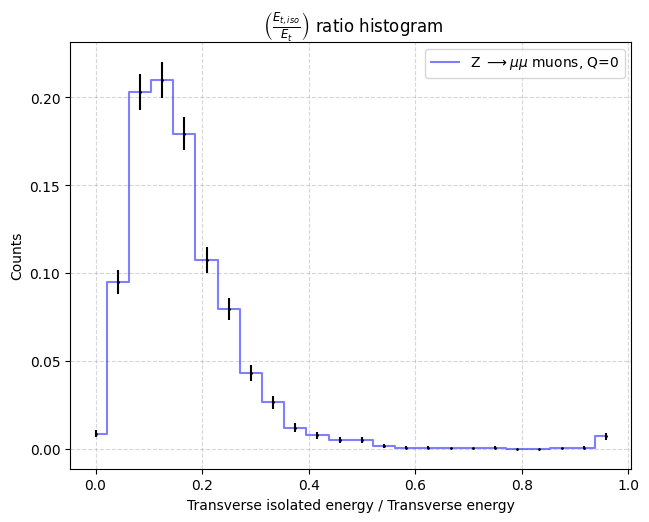

In [4]:
ratio=data2/data1
colors=['b']
labels=[r'Z $\longrightarrow \mu \mu$ muons, Q=0']
coolplot([ratio],np.linspace(0,1,25),colors,labels,"Transverse isolated energy / Transverse energy","Counts",
         r" $\left(\frac{{E_{t, iso}}}{{E_{t}}}\right)$ ratio histogram")

In [5]:
pt_events=MuonTree_ZeroBias["muon_pt"].array()[0:30000]
eta_events=MuonTree_ZeroBias["muon_eta"].array()[0:30000]
phi_events=MuonTree_ZeroBias["muon_phi"].array()[0:30000]

data1=ak.flatten(pt_events)
isolation =muon_isolation_all_events(MuonTree_ZeroBias, eta_events, phi_events, 0.0, 0.4, [0,1000], 500)
data2=ak.flatten(isolation)

100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


In [6]:
ratio=data2/data1
colors=['b']
labels=[r'Z $\longrightarrow \mu \mu$ muons, Q=0']
coolplot([ratio],np.linspace(0,1,25),colors,labels,"Transverse isolated energy / Transverse energy","Counts",
         r" $\left(\frac{{E_{t, iso}}}{{E_{t}}}\right)$ ratio histogram")

ValueError: cannot broadcast RegularArray of size 40 with RegularArray of size 28449 in divide